In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from math import floor,ceil,sqrt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
stock_ticker = 'AAPL'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.date.today()

In [3]:
df = yf.download(stock_ticker, start = start_date, end = end_date, progress=False)
df["Date"] = df.index
df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
df['Date'] = pd.to_datetime(df.Date,format='%Y/%m/%d')
print(df.head())
df.index = df['Date']

        Date      Open      High       Low     Close     Volume
0 2010-01-04  7.622500  7.660714  7.585000  7.643214  493729600
1 2010-01-05  7.664286  7.699643  7.616071  7.656429  601904800
2 2010-01-06  7.656429  7.686786  7.526786  7.534643  552160000
3 2010-01-07  7.562500  7.571429  7.466071  7.520714  477131200
4 2010-01-08  7.510714  7.571429  7.466429  7.570714  447610800


In [4]:
df.dropna(inplace=True)

Text(0.5, 1.0, 'Stock Price over the Years')

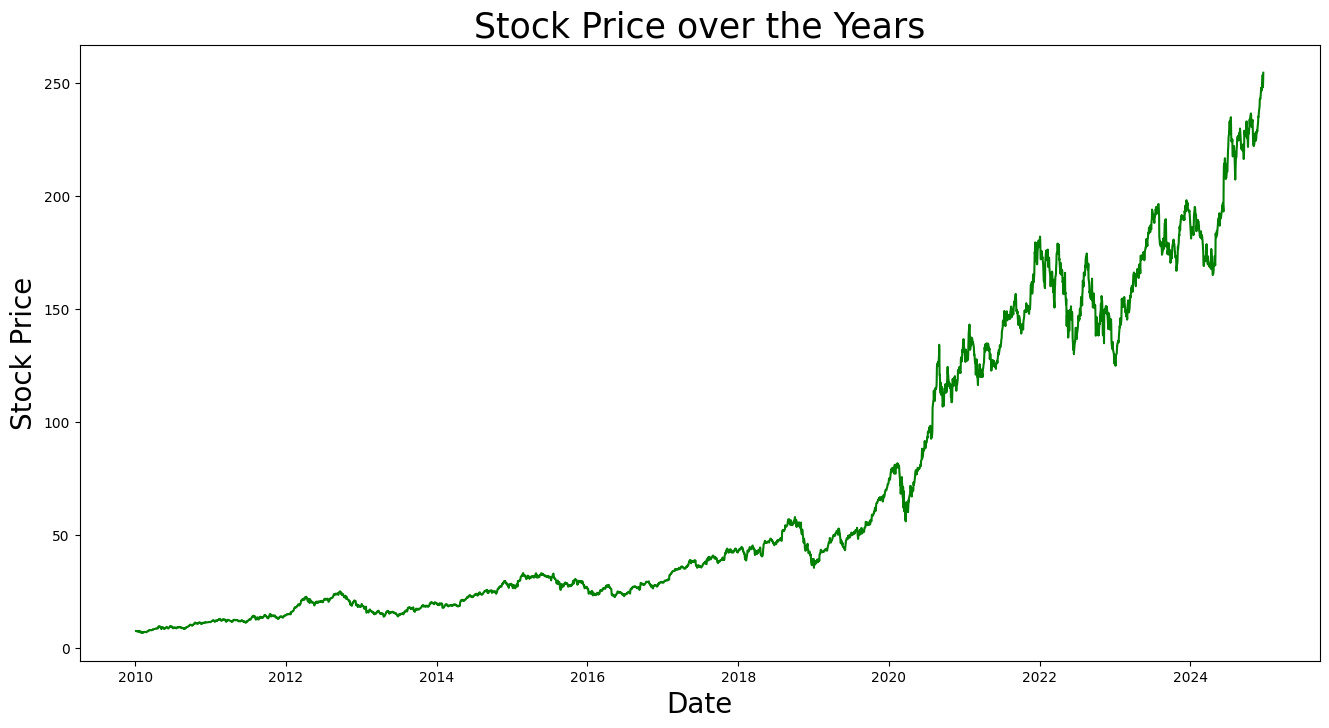

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price over the Years',size=25)

In [6]:
df_new=df[['Close']]
df_new.head()
dataset = df_new.values

In [7]:
shape=df.shape[0]
train=df_new[:ceil(shape*0.75)]
valid=df_new[ceil(shape*0.75):]

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
scaleddata = scaler.fit_transform(dataset)

In [10]:
xtrain, ytrain = [], []
for i in range(50,len(train)):
    xtrain.append(scaleddata[i-50:i,0])
    ytrain.append(scaleddata[i,0])

In [11]:
xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1],1))

In [12]:
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(50, 1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
history = model.fit(xtrain, ytrain, epochs=20, batch_size=32, validation_split=0.2, callbacks=[earlystopping], verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0011 - val_loss: 7.3809e-04
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 6.2827e-05 - val_loss: 5.9764e-04
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 4.5532e-05 - val_loss: 8.1202e-04
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 3.7422e-05 - val_loss: 2.2487e-04
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 2.9901e-05 - val_loss: 1.7059e-04
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 3.4946e-05 - val_loss: 1.7807e-04
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 2.7955e-05 - val_loss: 3.0121e-04
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 2.7545e-05 - val_loss: 1.5229e-04
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 2.8931e-05 - val_loss: 1.9806e-04
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 2.7668e-05 - val_loss: 1.4335e-04
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 3.0967e-05 -

In [15]:
inputs = df_new[len(df_new) - len(valid) - 50:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [16]:
xtest = []
for i in range(50,inputs.shape[0]):
    xtest.append(inputs[i-50:i,0])
xtest = np.array(xtest)
xtest = np.reshape(xtest, (xtest.shape[0],xtest.shape[1],1))

In [17]:
prediction = model.predict(xtest)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


In [18]:
prediction = scaler.inverse_transform(prediction)

In [19]:
mape = mean_absolute_percentage_error(valid, prediction) * 100
print(f"MAPE: {mape}")

MAPE: 2.1853867525036694


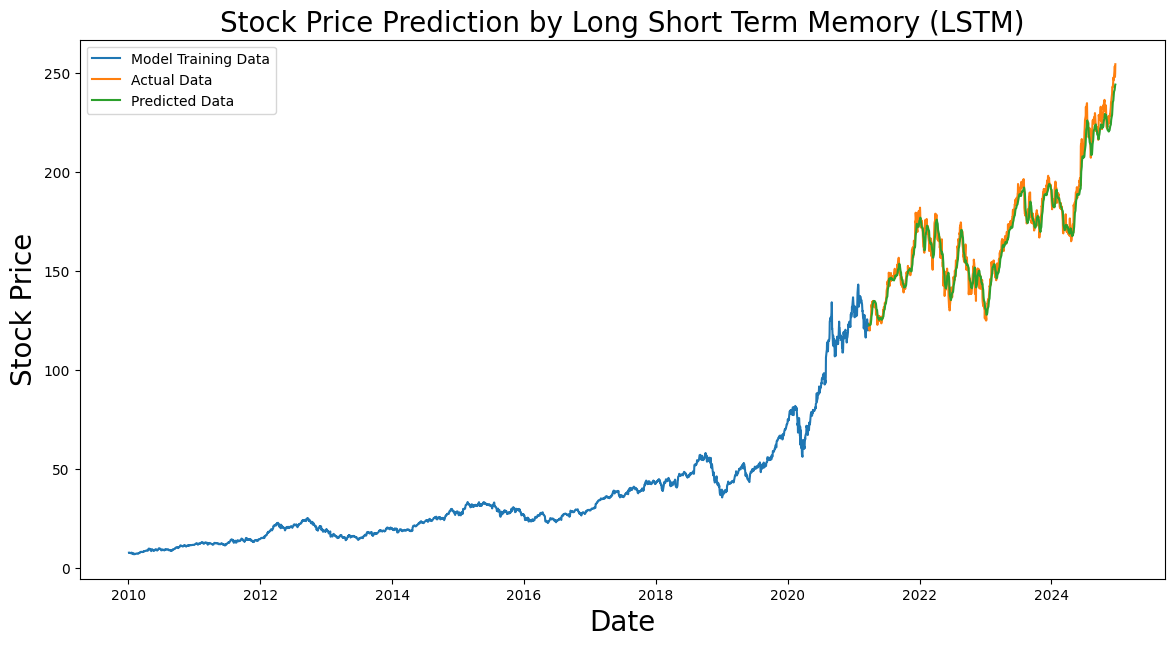

In [20]:
valid['Predictions'] = prediction
plt.figure(figsize=(14, 7))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

In [21]:
endprice = []
endprice.append(inputs[-50:,0])
endprice = np.array(endprice)
endprice = np.reshape(endprice, (endprice.shape[0],endprice.shape[1],1))
endprice

array([[[0.89120912],
        [0.90635262],
        [0.91665021],
        [0.90829097],
        [0.9097851 ],
        [0.92129419],
        [0.9272708 ],
        [0.9247671 ],
        [0.90417192],
        [0.9034047 ],
        [0.90679683],
        [0.91483294],
        [0.91592329],
        [0.90150671],
        [0.88458637],
        [0.87247157],
        [0.8688371 ],
        [0.87465221],
        [0.87170429],
        [0.89092641],
        [0.88882656],
        [0.87780205],
        [0.87780205],
        [0.8813961 ],
        [0.89391475],
        [0.88091153],
        [0.89310711],
        [0.89415704],
        [0.89706459],
        [0.89512624],
        [0.90057786],
        [0.91269266],
        [0.92153647],
        [0.92101148],
        [0.93070335],
        [0.93982981],
        [0.95218689],
        [0.95364067],
        [0.95376181],
        [0.95295417],
        [0.9687438 ],
        [0.97286285],
        [0.96769388],
        [0.97363013],
        [0.97431663],
        [0

In [22]:
predictedprice = model.predict(endprice)
predictedprice = scaler.inverse_transform(predictedprice)
predictedprice

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[245.14363]], dtype=float32)